<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/pyompa_dev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gsw

     |████████████████████████████████| 2.4 MB 4.2 MB/s 


In [2]:
import gsw

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-08-10 21:14:15--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 64.233.187.139, 64.233.187.102, 64.233.187.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.187.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kfrpplhrs852b6colgsh3cultck3tugs/1628630025000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-08-10 21:14:16--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kfrpplhrs852b6colgsh3cultck3tugs/1628630025000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-d

In [4]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 1041 (delta 237), reused 199 (delta 110), pack-reused 692
Receiving objects: 100% (1041/1041), 14.90 MiB | 11.92 MiB/s, done.
Resolving deltas: 100% (723/723), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 21e8668d1fa2e97abcc3c4a29446c07bff050af2 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu Jul 29 11:36:17 2021 -0700

    bugfix endmember_name_column
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [5]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [6]:
import pandas as pd
import numpy as np

def augment_df_with_PO_NO_SiO(df):  
    #remineralization ratios
    r_PO = 155;
    r_SiO = 15
    r_NO = 9.68
    df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
    df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
    df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO
    return df

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "lat"
header[9] = "lon"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["lon"],
                                   lat=gp15_df["lat"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sigma0"] = sig0

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["lat"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["Depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["lat"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [7]:
gp15_df

stnnbr  c2  c3  c4  ...     sigma0        Depth  spiciness            PV
0        1.0   3  36  36  ...  24.052467     2.477227  -1.235624 -6.847071e-10
2        1.0   3  24  24  ...  24.533620    30.715490  -1.050415 -7.829064e-10
3        1.0   3  18  18  ...  24.737235    40.721797  -1.209639 -7.433318e-10
4        1.0   3  13  13  ...  24.894944    50.133222  -1.080744 -6.155510e-10
5        1.0   3   7   7  ...  25.144753    70.638720  -1.230846 -3.744648e-10
...      ...  ..  ..  ..  ...        ...          ...        ...           ...
1137    39.0  12  16  17  ...  27.760561  3000.792840  -0.117884 -2.062249e-12
1138    39.0  12  13  14  ...  27.779610  3401.198658  -0.122707 -1.730980e-12
1139    39.0  12  10  11  ...  27.795069  3801.952551  -0.128901 -1.164123e-12
1140    39.0  12   7   8  ...  27.801685  4107.626461  -0.130510 -6.648035e-13
1141    39.0  12   4   5  ...  27.802891  4186.879292  -0.130929 -6.116598e-13

[926 rows x 39 columns]

In [8]:
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv -O GP15_intermediateanddeep_endmemberswithsubtypes.csv

--2021-08-10 21:14:29--  https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv [following]
--2021-08-10 21:14:29--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3379 (3.3K) [text/plain]
Saving to: ‘GP15_intermediateanddeep_endmemberswithsubtypes.csv’

GP15_intermediatean 

In [9]:
import pandas
endmember_df = pandas.read_csv("GP15_intermediateanddeep_endmemberswithsubtypes.csv")

#additional_rows = pandas.DataFrame(
#    {"watermass_name": ["PSUW", "ESSW"],
#     "conservative_temp": [4.03, 12.2],
#     "absolute_salinity": [33.38, 34.86],
#     "oxygen": [174.7, 84.6],
#     "phosphate": [1.87, 3.03],
#     "silicate": [21.58, 168.87],
#     "nitrate": [25.87, 43.5]
#    }
#)
endmember_df = augment_df_with_PO_NO_SiO(endmember_df)

In [10]:
endmember_df

watermass_name  conservative_temp  ...          NO          SiO
0          AABW_0          -0.246976  ...  544.245206  2042.304061
1          AAIW_0           4.446683  ...  507.419652   538.490310
2          AAIW_1           5.031174  ...  504.924013   445.616811
3         ENPCW_0          14.489434  ...  271.665572   297.297335
4         ENPCW_1           6.057364  ...  423.790742   985.755554
5          ESSW_0          10.491828  ...  346.951770   554.321923
6          ESSW_1          16.294648  ...  282.550209   282.342073
7          EqIW_0           5.470202  ...  454.487000  1123.678774
8          EqIW_1           8.694829  ...  384.553888   674.554073
9          LCDW_0           0.680998  ...  516.953412  1970.092000
10         LCDW_1           1.508063  ...  493.528460  1645.982098
11         NPIW_0           9.087524  ...  375.024406   807.906297
12         NPIW_1           3.162491  ...  449.682766  2022.095673
13         NPIW_2           4.752850  ...  443.300800  1360.690000
14          PDW_0           1.964242  ...  457.398126  2595.937711
15          PDW_1           1.205063  ...  495.282495  2657.664355
16         PSUW_0           4.601224  ...  457.089059  1177.065041
17         PSUW_1           5.836636  ...  446.496735   635.282492
18         SPCW_0           8.559362  ...  396.222338   300.427824
19         SPCW_1          18.682819  ...  214.167070   213.271636
20         UCDW_0           2.466866  ...  498.811927  1426.948695

[21 rows x 12 columns]

In [11]:
import json

#gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sigma0"] >= 26.6)])
!wget https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json -O station_to_tc_cutoffs.json 
station_to_tcstartend = json.loads(open("station_to_tc_cutoffs.json").read())
gp15_intermediateanddeep = gp15_df[
    gp15_df.apply(lambda x: x['Depth'] > station_to_tcstartend[str(int(x['stnnbr']))]['depth_cutoffs'][1], axis=1)]

--2021-08-10 21:14:30--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13389 (13K) [text/plain]
Saving to: ‘station_to_tc_cutoffs.json’

station_to_tc_cutof 100%[===================>]  13.08K  --.-KB/s    in 0s      

2021-08-10 21:14:30 (49.0 MB/s) - ‘station_to_tc_cutoffs.json’ saved [13389/13389]



Visualize the end-members

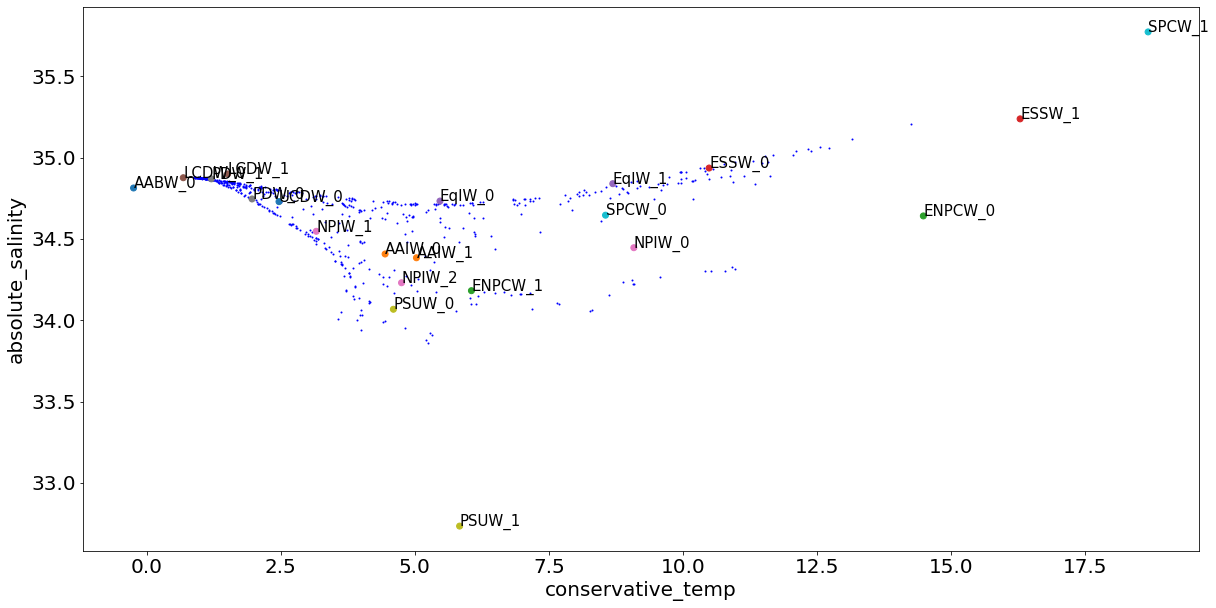

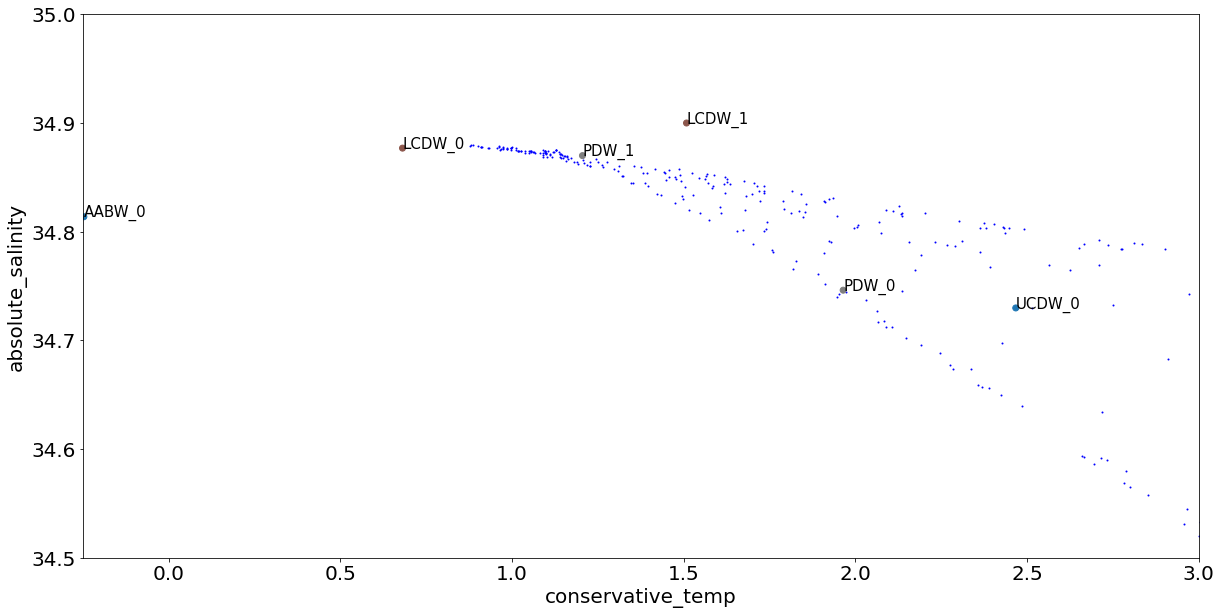

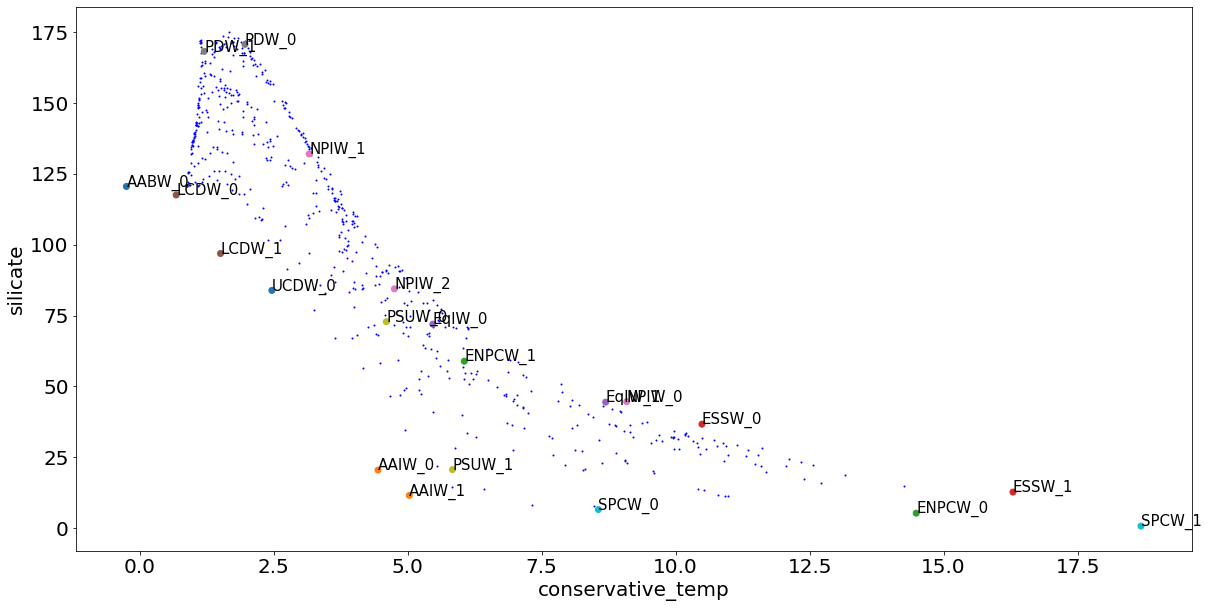

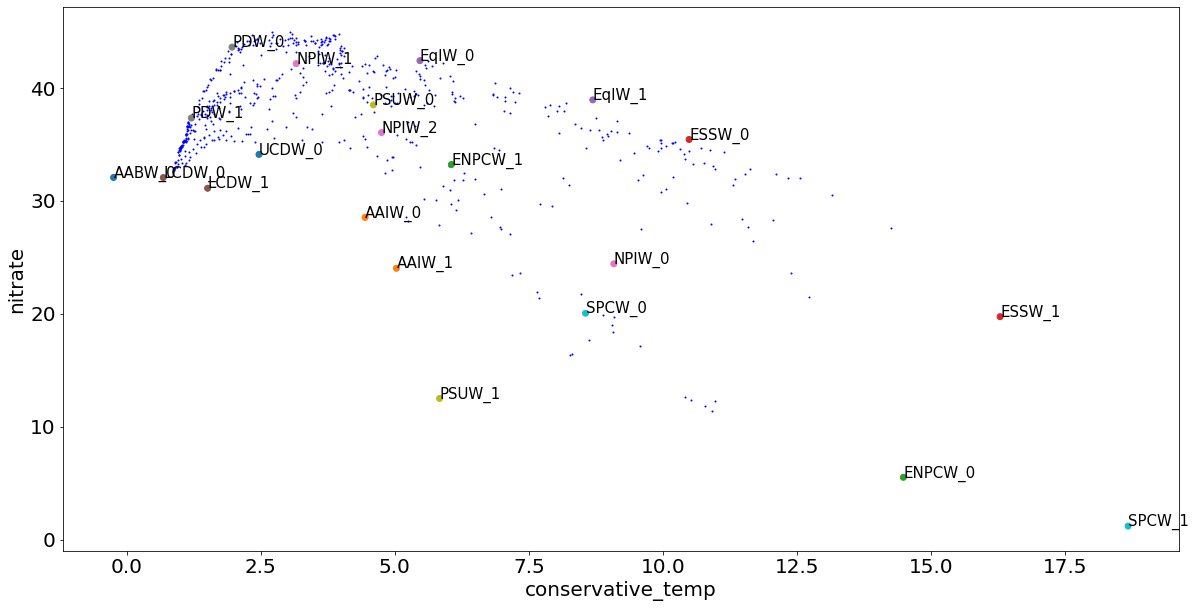

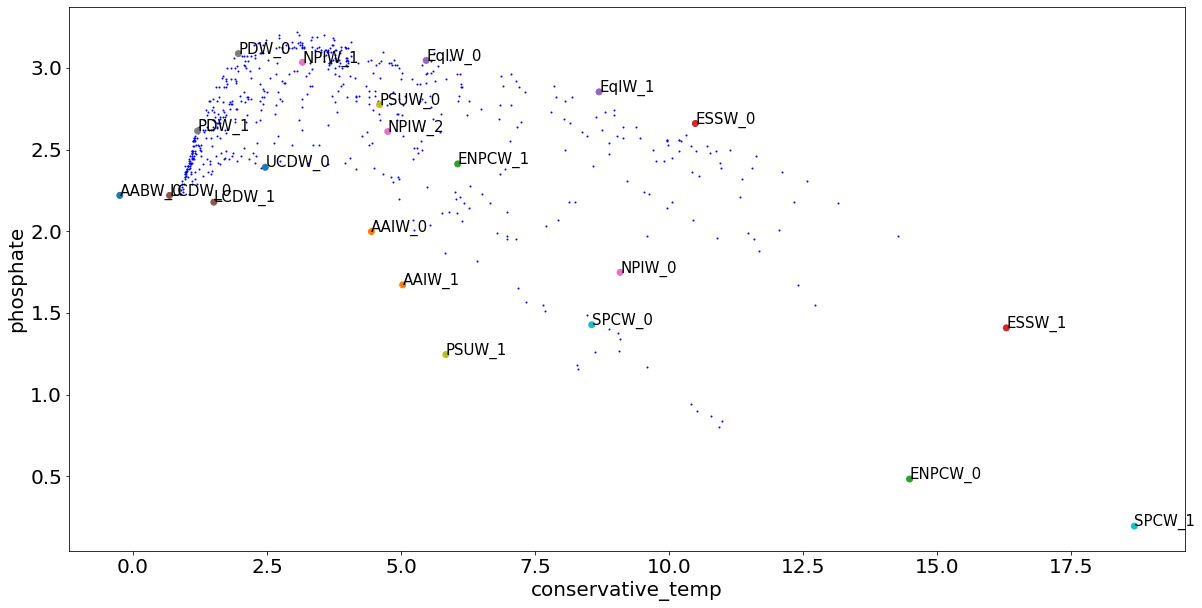

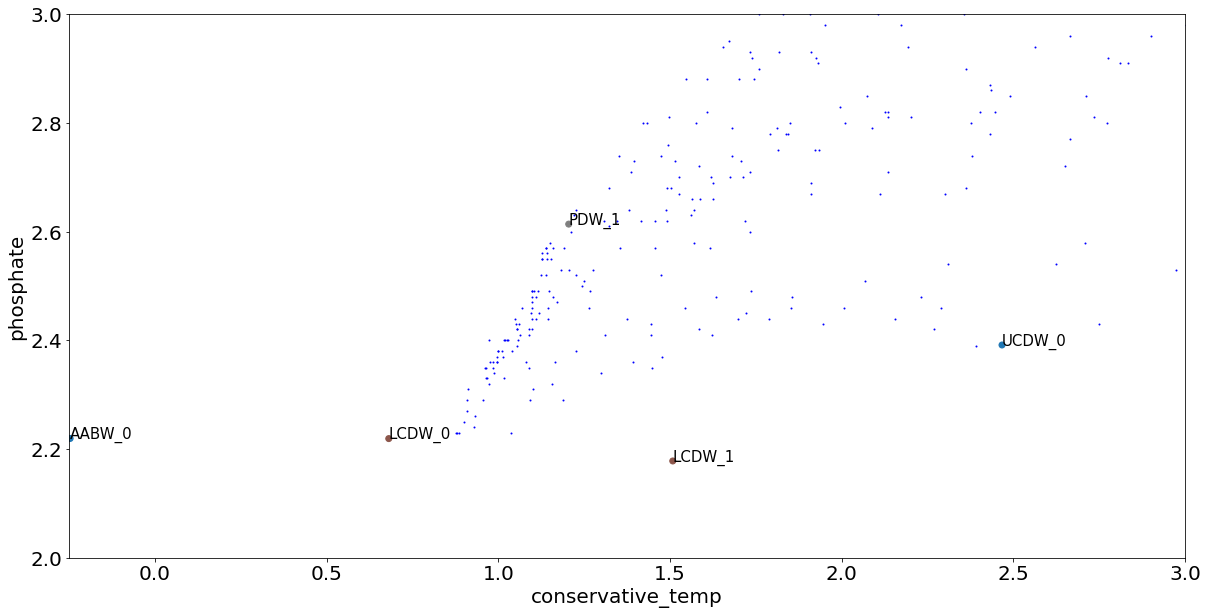

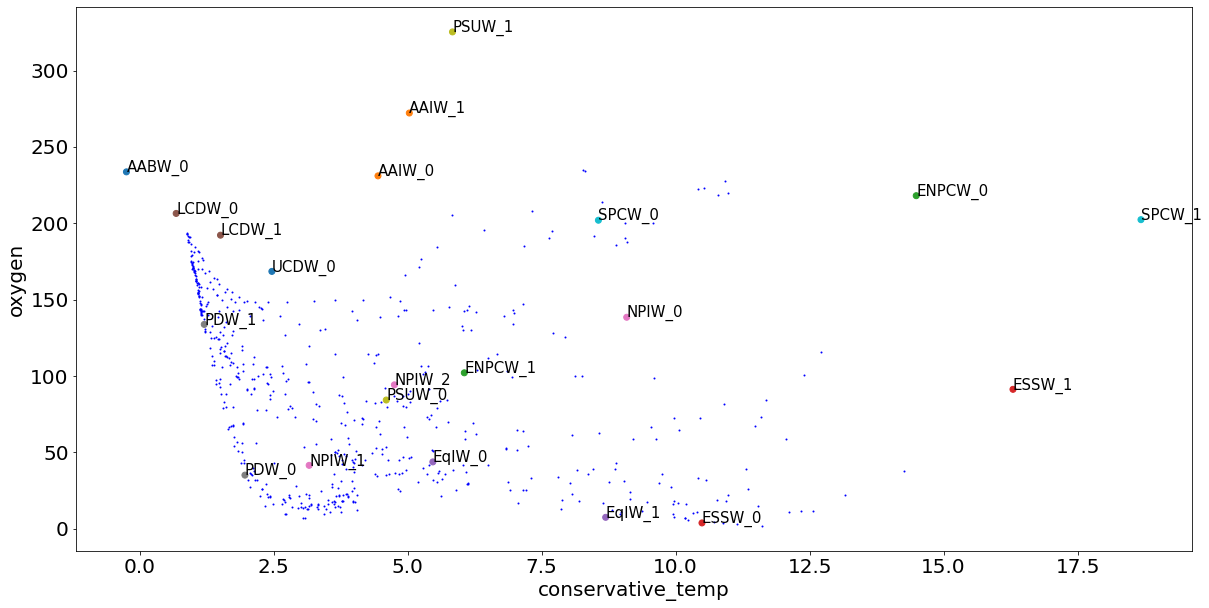

In [12]:
import matplotlib
from matplotlib import pyplot as plt
import pyompa

matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

endmember_names = endmember_df["watermass_name"]
endmembername_to_indices = pyompa.util.get_endmember_idx_mapping(
                            endmember_names)

colors = ["C0"]*len(endmember_names)
for endmembertypeidx, endmembertype in enumerate(
      endmembername_to_indices.keys()):
  for idx in endmembername_to_indices[endmembertype]:
    colors[idx] = "C"+str(endmembertypeidx)

def make_paired_feature_plot(feature1name, feature2name, xlim=None, ylim=None):
    feature1vals = endmember_df[feature1name]
    feature2vals = endmember_df[feature2name]
    obsdf_feature1vals = gp15_intermediateanddeep[feature1name]
    obsdf_feature2vals = gp15_intermediateanddeep[feature2name]
    
    plt.figure(figsize=(20,10))
    
    ax = plt.gca()
    for i, txt in enumerate(endmember_names):
        plotme = True
        if (xlim is not None and (feature1vals[i] < xlim[0] or feature1vals[i]>xlim[1])):
            plotme = False
        if (ylim is not None and (feature2vals[i] < ylim[0] or feature2vals[i]>ylim[1])):
            plotme = False
        if (plotme):
            ax.annotate(txt, (feature1vals[i], feature2vals[i]), size=15)    
    plt.scatter(obsdf_feature1vals, obsdf_feature2vals, color="blue", s=1)
    plt.scatter(feature1vals, feature2vals, color=colors)
    plt.xlabel(feature1name)
    plt.ylabel(feature2name)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.show()

#if you want to zoom into a region...


make_paired_feature_plot("conservative_temp", "absolute_salinity")
make_paired_feature_plot("conservative_temp", "absolute_salinity",
                         xlim=(-0.25, 3), ylim=(34.5,35))

make_paired_feature_plot("conservative_temp", "silicate")
make_paired_feature_plot("conservative_temp", "nitrate")

make_paired_feature_plot("conservative_temp", "phosphate")
make_paired_feature_plot("conservative_temp", "phosphate",
                         xlim=(-0.25, 3), ylim=(2,3))

make_paired_feature_plot("conservative_temp", "oxygen")

matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [13]:
from collections import OrderedDict

intermediateanddeep_settingtosoln = OrderedDict()

In [14]:
import pyompa
reload(pyompa)
from pyompa import OMPAProblem, EndMemExpPenaltyFunc
from collections import OrderedDict
import json


convertedparamgroups_staticremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -155, "phosphate": 1.0, "nitrate": 16.0}],
        always_positive=False)
]

convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -155*(66.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(66.0/106.0)},
                           #Representing C:P = 209
                           {"oxygen": -155*(209.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(209.0/106.0)}
                          ],
        always_positive=False)
]

rian_weighting = {
    "conservative_temp": 56.0,
    "absolute_salinity": 80.0,
    "silicate": 3.0,
    "nitrate": 5.0,
    "phosphate": 5.0,
    "oxygen": 1.0,
    "NO": 1.0,
    "PO": 0.5
}

withconversion_paramnames = ["conservative_temp", "absolute_salinity",
                             "silicate", "nitrate", "phosphate", "oxygen"]
noconversion_paramnames = ["conservative_temp", "absolute_salinity",
                           "silicate", "NO", "PO"]  

flexiblereminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_flexibleremineralization}

staticreminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_staticremineralization}

noremin_settings = {
    "param_names": noconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": []}

endmember_usagepenalty = { 
    "ENPCW_0": EndMemExpPenaltyFunc(
        spec={
            'sigma0':{'type':'density_default', 'upperbound':27.0},
            'lat': {'type':'latlon_default', 'lowerbound':0}
            }),
    "ENPCW_1": EndMemExpPenaltyFunc(
        spec={
            'sigma0':{'type':'density_default', 'upperbound':27.0},
            'lat': {'type':'latlon_default', 'lowerbound':0}
            }),

    "SPCW_0": EndMemExpPenaltyFunc(
        spec={
            'lat': {'type':'latlon_default', 'upperbound':0}
            }),
    "SPCW_1": EndMemExpPenaltyFunc(
        spec={
            'lat': {'type':'latlon_default', 'upperbound':0}
            }),

    "PSUW_0": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':10}}),
    "PSUW_1": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':10}}),

    "ESSW_0": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':-25, 'upperbound':25}}),
    "ESSW_1": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':-25, 'upperbound':25}}),

    "EqIW_0": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'upperbound':20}}),
    "EqIW_1": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'upperbound':20}}),
    
    "LCDW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.7}}),
    "LCDW_1": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.7}}),

    "PDW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.3}}),
    "PDW_1": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.3}}),


    "AAIW_0": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'upperbound':10}}),
    "AAIW_1": EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'upperbound':10}}),
    
    "UCDW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.3}}),

    "AABW_0": EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.8},
              'lat': {'type': 'latlon_default', 'upperbound': 30} })
}


for setting_name, setting, endmember_df_touse, usagepenalty_touse in [
    ("flexiblereminratio_manyarchetypes", flexiblereminratio_settings, endmember_df, endmember_usagepenalty),
    
                              #("staticreminratio", staticreminratio_settings),
                              #("noremin_settings", noremin_settings)
                              ]:
    print("On setting:", setting_name)
    ompa_soln = OMPAProblem(
              obs_df=gp15_intermediateanddeep,
              endmembername_to_usagepenaltyfunc=usagepenalty_touse,
              **setting).solve(
                  endmember_df_touse,
                  endmember_name_column="watermass_name",
                  batch_size=100)
    intermediateanddeep_settingtosoln[setting_name] = ompa_soln

On setting: flexiblereminratio_manyarchetypes
Adding penalty for ENPCW_0
Adding penalty for ENPCW_1
Adding penalty for SPCW_0
Adding penalty for SPCW_1
Adding penalty for PSUW_0
Adding penalty for PSUW_1
Adding penalty for ESSW_0
Adding penalty for ESSW_1
Adding penalty for EqIW_0
Adding penalty for EqIW_1
Adding penalty for LCDW_0
Adding penalty for LCDW_1
Adding penalty for PDW_0
Adding penalty for PDW_1
Adding penalty for AAIW_0
Adding penalty for AAIW_1
Adding penalty for UCDW_0
Adding penalty for AABW_0
Endmember-idx mapping is
 OrderedDict([('AABW', [0]), ('AAIW', [1, 2]), ('ENPCW', [3, 4]), ('ESSW', [5, 6]), ('EqIW', [7, 8]), ('LCDW', [9, 10]), ('NPIW', [11, 12, 13]), ('PDW', [14, 15]), ('PSUW', [16, 17]), ('SPCW', [18, 19]), ('UCDW', [20])])
params to use: ['conservative_temp', 'absolute_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [56. 80.  3.  5.  5.  1.]
Matrix A:
Trying convertedvariable sign constraint: [1 1]
On example 0 to 100 out of 594
stat

Plotting endmember fractions
Setting: flexiblereminratio_manyarchetypes


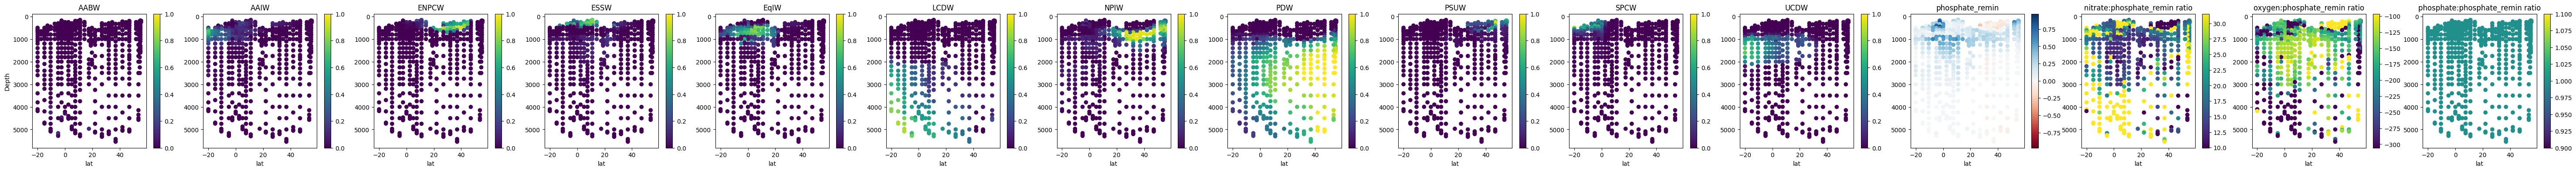

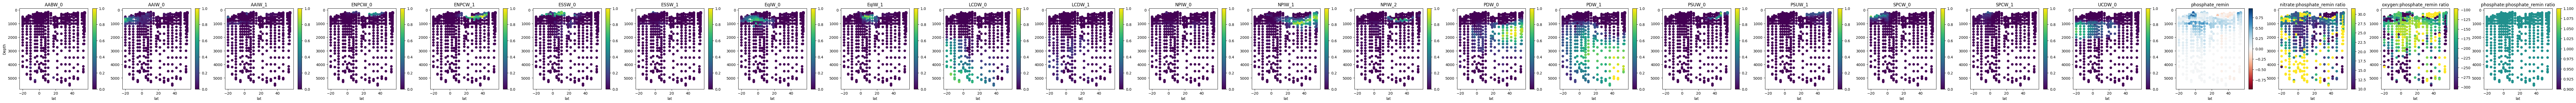

Plotting absolute residuals
Setting: flexiblereminratio_manyarchetypes


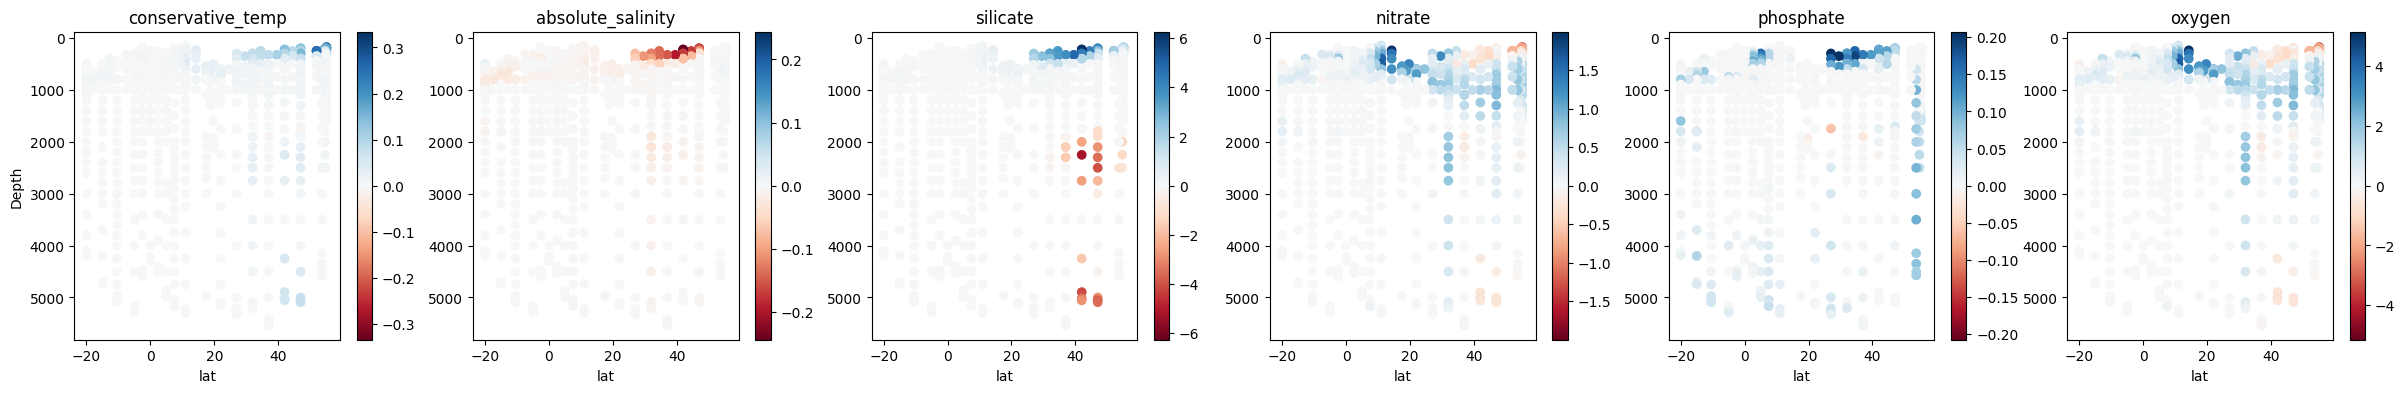

Plotting penalties
Setting: flexiblereminratio_manyarchetypes


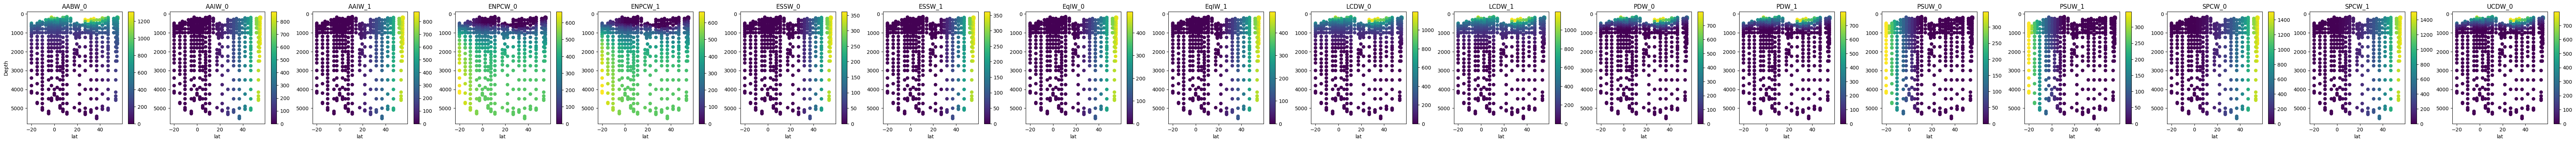

In [15]:
import numpy as np
from matplotlib import pyplot as plt
reload(pyompa)
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)


print("Plotting endmember fractions")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=False)


print("Plotting absolute residuals")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname="Depth")
    
print("Plotting penalties")
for setting in intermediateanddeep_settingtosoln:
    print("Setting:", setting)
    ompa_soln = intermediateanddeep_settingtosoln[setting]
    plot_ompasoln_endmember_usagepenalties(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname="Depth")

In [16]:
INTERANDDEEP_SETTINGTOUSE = "flexiblereminratio_manyarchetypes"

### Intermediate and deep waters uncertainty analysis

In [ ]:
#quantify variation in min/max for each endmember and the remineralization amount
from mpl_toolkits.axes_grid1 import make_axes_locatable
reload(pyompa)
from pyompa.util import collapse_endmembers_by_idxmapping, organize_converted_vars_by_groupname
from pyompa.plotting import plot_residuals, plot_endmember_fractions

soln = intermediateanddeep_settingtosoln[INTERANDDEEP_SETTINGTOUSE]
#soln = intermediateanddeep_settingtosoln["flexiblereminratio_onearchetype"]

#max_resids = np.array([0.01, 0.04, 4, 1, 0.15, 2])
max_resids = np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])

interanddeep_ambiguity_results_max = {}
interanddeep_ambiguity_results_min = {}

for endmemberoverallidx, (endmembername, endmember_idxs) in enumerate(soln.endmembername_to_indices.items()):
    if (True):#endmembername in ["ESSW"]):
        print("On",endmembername)
        maximizing_obj = np.zeros((len(soln.endmember_names) + soln.ompa_problem.num_converted_variables,))
        maximizing_obj[endmember_idxs] = -1
        
        ompasoln_max = pyompa.ompacore.OMPASoln.core_quantify_ambiguity_via_residual_limits(
                                      self=soln, obj_weights=maximizing_obj,
                                      max_resids=max_resids)
        interanddeep_ambiguity_results_max[endmembername] = ompasoln_max
        
        minimizing_obj = np.zeros((len(soln.endmember_names) + soln.ompa_problem.num_converted_variables,))
        minimizing_obj[endmember_idxs] = 1
        ompasoln_min = pyompa.ompacore.OMPASoln.core_quantify_ambiguity_via_residual_limits(
                                      self=soln, obj_weights=minimizing_obj, max_resids=max_resids)
        interanddeep_ambiguity_results_min[endmembername] = ompasoln_min
        

        """print("Original")
        plot_ompasoln_endmember_fractions(ompa_soln=soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
                
        print("With min fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_min,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        print("With max fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_max,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)"""
        
        """print("original")
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
        origscatter = ax[0].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                                    c=collapsed_fractions[:,endmemberoverallidx],
                                    vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(origscatter, cax=cax)
        ax[0].set_title("Original")
        ax[0].set_ylabel("-Depth")

        lowerscatter = ax[1].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                       c=minwm, #- collapsed_fractions[:,endmemberoverallidx]
                       vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(lowerscatter, cax=cax)
        ax[1].set_title("Lowerbound")

        upperscatter = ax[2].scatter(soln.obs_df["lat"], -soln.obs_df["Depth"],
                               c=-maxwm, #- collapsed_fractions[:,endmemberoverallidx]
                               vmin=0, vmax=1.0)
        divider = make_axes_locatable(ax[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(upperscatter, cax=cax)
        ax[2].set_title("Upperbound")

        plt.show()"""

On AABW
On AAIW
On ENPCW


## Thermocline Analysis

In [18]:
#Thermocline files include endmembers in the range of potential density 21 to 27 
#conservative temeprature added in place of PO column
 
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ENPCW_Jul2021.csv -O ENPCW_Jul2021.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/PSUW_Jul2021.csv -O PSUW_Jul2021.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ESSW_Jul2021.csv -O ESSW_Jul2021.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/SPCW_Jul2021.csv -O SPCW_Jul2021.csv
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/SPSTSW.csv -O SPSTSW.csv

--2021-08-10 21:17:38--  https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/ENPCW_Jul2021.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/ENPCW_Jul2021.csv [following]
--2021-08-10 21:17:38--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/ENPCW_Jul2021.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51227 (50K) [text/plain]
Saving to: ‘ENPCW_Jul2021.csv’

ENPCW_Jul2021.csv   100%[===================>]  50.03K  --.-KB/s    in 0.01s   

2021-08-10 21:17:39 (3.78 MB/s) - ‘ENPCW_Jul2021.csv’ saved [51227/51227]



In [19]:
print("First ten rows")
!head "PSUW_Jul2021.csv"
print("last ten rows")
!tail "PSUW_Jul2021.csv"

First ten rows
21,188.97,73.737,-658.06,298.07,224.41,19.578,188.73,-230.07,-426.77,108.86,188.96
21.01,187.2,73.289,-648.57,295.01,221.95,19.362,186.96,-227.79,-421.67,106.12,187.19
21.02,185.44,72.844,-639.15,291.98,219.5,19.148,185.2,-225.53,-416.6,103.4,185.42
21.03,183.69,72.403,-629.8,288.96,217.06,18.936,183.45,-223.28,-411.57,100.7,183.67
21.04,181.95,71.965,-620.51,285.97,214.65,18.724,181.72,-221.05,-406.58,98.013,181.93
21.05,180.22,71.529,-611.28,282.99,212.25,18.515,179.99,-218.83,-401.62,95.347,180.21
21.06,178.51,71.097,-602.11,280.04,209.87,18.307,178.28,-216.62,-396.69,92.701,178.49
21.07,176.8,70.668,-593.01,277.11,207.51,18.1,176.58,-214.43,-391.8,90.074,176.79
21.08,175.11,70.242,-583.98,274.2,205.16,17.895,174.89,-212.26,-386.94,87.465,175.1
21.09,173.43,69.819,-575,271.31,202.83,17.692,173.22,-210.1,-382.12,84.875,173.42
last ten rows
26.91,4.0493,33.892,60.807,82.735,40.945,2.9078,4.0552,250.16,53.495,-148.9,4.0668
26.92,4.0245,33.902,57.487,83.96,41.253,2.9281,4

In [21]:

def read_in_thermocline_endmemberdfs(endmemname_to_csv):
    #This function reads in the data frames for the thermocline end members
    #It takes endmemname_to_csv as input, which maps the thermocline
    # end member name (e.g. ENPCW) to the corresponding csv file.
    endmemname_to_df = {}
    #iterate through every endmemname in endmemname_to_csv
    #Order of thermocline endmember file columns: Sig0 pt SP O Si N P PO Pres spic0 vor NO Lat Lon T]);
    #e.g.
    header = ["c"+str(i) for i in range(1,17)] 
    header[0] = "sigma0" #potential density 
    header[1] = "potential_temp"
    header[2] = "practical_salinity"
    header[3] = "oxygen"
    header[4] = "silicate"
    header[5] = "nitrate"
    header[6] = "phosphate"
    header[7] = "CT" 
    header[8] = "CTD pressure"
    header[9] = "latitude"
    header[10] = "longitude"
    header[11] = "CTD temperature"

    #make sure header names are compatible
    # with those used in the prepare_endmember_df function defined earlier
    # for intermediate waters.
    for endmemname in endmemname_to_csv.keys():
        #get the csv file corresponding to the endmemname
        csv = endmemname_to_csv[endmemname]
        #read the csv file into a data frame df
        df = pd.read_csv(csv,names=header, na_values = -999)
        augment_df_with_PO_NO_SiO(df)
        #Also add a column to the df that just has the end member name
        # repeated for each row. This will come in handy later when
        # pairing rows from different data frames
        #df["watermassname"] = endmemname
        #store df in endmemname_to_df with the key endmemname
        endmemname_to_df[endmemname] = df;
        absolute_salinity = gsw.SA_from_SP(SP=df["practical_salinity"],
                                   p=df["CTD pressure"],
                                   lon=df["longitude"],
                                   lat=df["latitude"])
        df["absolute_salinity"] = absolute_salinity
        conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                          t=df["CTD temperature"],
                                          p=df["CTD pressure"])
        df["conservative_temp"] = conservative_temp
    return endmemname_to_df


#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW_tc": "PSUW_Jul2021.csv",
    "ENPCW_tc": "ENPCW_Jul2021.csv",
    "ESSW_tc": "ESSW_Jul2021.csv",
    "SPCW_tc": "SPCW_Jul2021.csv",
    "SPCSTSW_tc": "SPSTSW.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)


In [22]:
reload(pyompa)
reload(pyompa.thermocline_array)
from pyompa import ThermoclineArrayOMPAProblem
from collections import OrderedDict

#Define thermocline
#By convention, constants are in all caps
#TC_UPPER_BOUND = 26.6
#TC_LOWER_BOUND = 25.5
TC_UPPER_BOUND = 27
TC_LOWER_BOUND = 23.899
TC_STEP = 0.01
#therm_endmem_to_use = ["PSUW","ENPCW","ESSW", "SPCW"] #thermocline water masses for analysis
# members to use in the analysis 
#gp15_thermocline = gp15_df[(gp15_df["sigma0"] >= TC_LOWER_BOUND)
#                            & (gp15_df["sigma0"] <= TC_UPPER_BOUND)]
gp15_thermocline =  gp15_df[gp15_df.apply(
        lambda x: (x['Depth'] > station_to_tcstartend[str(int(x['stnnbr']))]['depth_cutoffs'][0])
              and (x['Depth'] < station_to_tcstartend[str(int(x['stnnbr']))]['depth_cutoffs'][1]), axis=1)]

rescale = 0.1 #for stabilizing the solver

thermocline_weighting = {
    "conservative_temp": rescale*200,
    "absolute_salinity": rescale*155,
    "silicate": rescale*5.0,
    "nitrate": rescale*50,
    "phosphate": rescale*50,
    "oxygen": rescale*10
}

settings_to_thermoclineomparesults = OrderedDict()

for (t_settingname, t_weighting) in [
          ('thermocline_weighting', thermocline_weighting),
          ]:
    print("setting name", t_settingname)
    settings_to_thermoclineomparesults[(t_settingname)] = ThermoclineArrayOMPAProblem(
         stratification_col="sigma0",
         tc_lower_bound=TC_LOWER_BOUND,
         tc_upper_bound=TC_UPPER_BOUND,
         tc_step=TC_STEP,
         obs_df=gp15_thermocline,
         param_names=withconversion_paramnames,
         convertedparam_groups=convertedparamgroups_flexibleremineralization,
         param_weightings=t_weighting
     ).solve(endmemname_to_df=endmemname_to_df)

setting name thermocline_weighting
Heads up! You specified a tc lower bound of 23.899 but the observations df contains samples with a sigma0 as low as 21.44979855816473
No observations for range 23.899 23.909000000000002
Endmember-idx mapping is
 OrderedDict([('ENPCW', [0]), ('ESSW', [1]), ('PSUW', [2]), ('SPCSTSW', [3]), ('SPCW', [4])])
params to use: ['conservative_temp', 'absolute_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [20.  15.5  0.5  5.   5.   1. ]
Matrix A:
Trying convertedvariable sign constraint: [1 1]
On example 0 to 1 out of 1
status: optimal
optimal value 110.38968463985097
Original weighted sum squares: 110.38968464357085
Post fix weighted sum squared: 110.38968465331446
Trying convertedvariable sign constraint: [-1 -1]
On example 0 to 1 out of 1
status: optimal
optimal value 1630.86236708071
Original weighted sum squares: 1630.8623670993552
Post fix weighted sum squared: 1630.862367138753
On example 0 to 1 out of 1
status: optimal
optimal

Plotting endmember fractions
thermocline_weighting


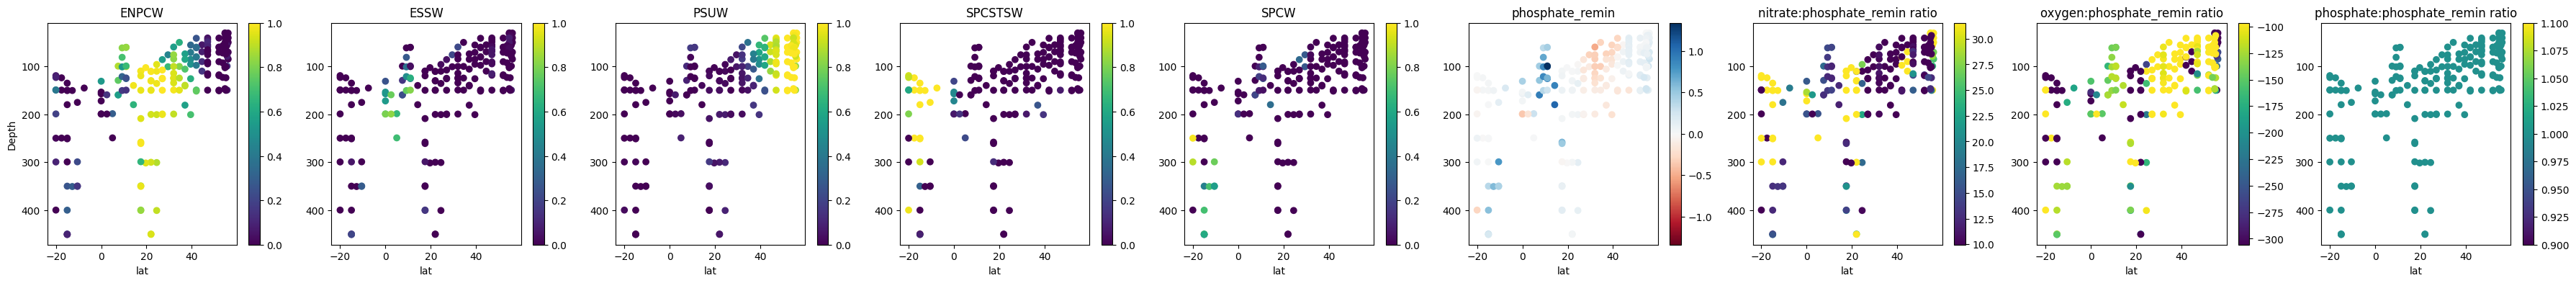

In [23]:
reload(pyompa)
from pyompa import plot_ompasoln_endmember_fractions

print("Plotting endmember fractions")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
    print(setting)
    plot_ompasoln_endmember_fractions(
      ompa_soln=thermocline_ompa_results, xaxis_colname="lat", yaxis_colname="Depth")

Plotting parameter residuals
thermocline_weighting


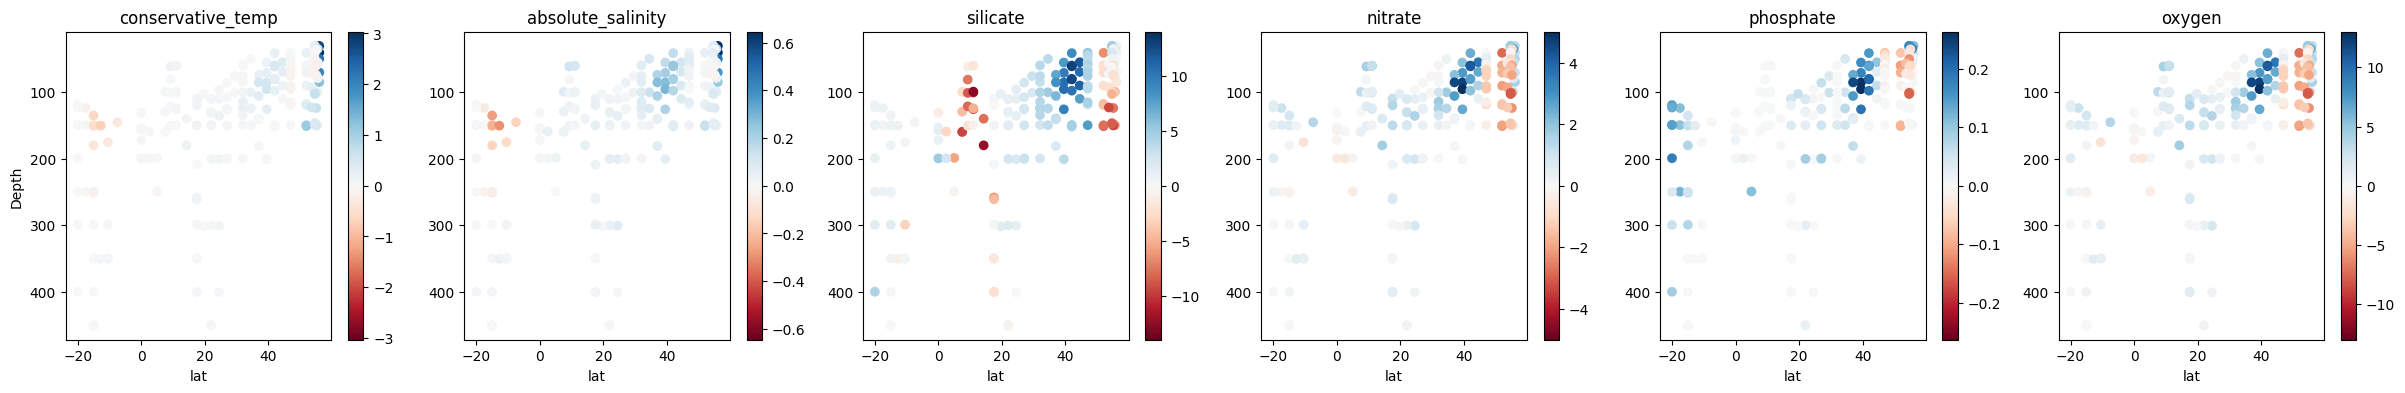

In [24]:
from pyompa import plot_ompasoln_residuals

print("Plotting parameter residuals")
for setting,thermocline_ompa_results in\
    settings_to_thermoclineomparesults.items():
    print(setting)
    plot_ompasoln_residuals(ompa_soln=thermocline_ompa_results,
                            xaxis_colname="lat", yaxis_colname="Depth")


In [25]:
THERMOCLINE_SETTINGTOUSE = "thermocline_weighting"

### Thermocline uncertainty analysis

In [26]:
reload(pyompa.ompacore)
reload(pyompa.thermocline_array)

#uncertainty analysis for the thermocline
soln = settings_to_thermoclineomparesults[THERMOCLINE_SETTINGTOUSE]
#max_resids = np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])*10
max_resids = np.array([0.001, 0.004, 0.4, 0.1, 0.015, 0.2])

thermocline_ambiguity_results_max = {}
thermocline_ambiguity_results_min = {}

for endmemberoverallidx, (endmembername, endmember_idxs) in enumerate(soln.endmembername_to_indices.items()):
    if (True):#endmembername in ["ESSW"]):
        print("On",endmembername)
        maximizing_obj = np.zeros((len(soln.endmember_names) + soln[0].ompa_problem.num_converted_variables,))
        maximizing_obj[endmember_idxs] = -1
        
        ompasoln_max = pyompa.thermocline_array.ThermoclineArraySoln.core_quantify_ambiguity_via_residual_limits(
                         self=soln, obj_weights=maximizing_obj,
                         max_resids=max_resids)
        thermocline_ambiguity_results_max[endmembername] = ompasoln_max
        
        minimizing_obj = np.zeros((len(soln.endmember_names) + soln[0].ompa_problem.num_converted_variables,))
        minimizing_obj[endmember_idxs] = 1
        ompasoln_min = pyompa.thermocline_array.ThermoclineArraySoln.core_quantify_ambiguity_via_residual_limits(
                         self=soln, obj_weights=minimizing_obj, max_resids=max_resids)
        thermocline_ambiguity_results_min[endmembername] = ompasoln_min
        
        """print("Original")
        plot_ompasoln_endmember_fractions(ompa_soln=soln,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        print("With min fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_min,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)
        print("With max fractions")
        plot_ompasoln_endmember_fractions(ompa_soln=ompasoln_max,
                                      xaxis_colname="lat",
                                      yaxis_colname="Depth",
                                      group_endmembers=True)"""
        
        #plot_residuals(param_residuals=new_resids_max, param_names=soln.param_names,
        #               xaxis_vals=soln.obs_df["lat"], xaxis_label="lat",
        #               yaxis_vals=soln.obs_df["Depth"], yaxis_label="Depth")
        #plot_residuals(param_residuals=new_resids_min, param_names=soln.param_names,
        #               xaxis_vals=soln.obs_df["lat"], xaxis_label="lat",
        #               yaxis_vals=soln.obs_df["Depth"], yaxis_label="Depth")

On ENPCW
On ESSW
On PSUW
On SPCSTSW
On SPCW


## Combining the results for intermediate & deep and the thermocline, plot and export

writing to baseresults.csv


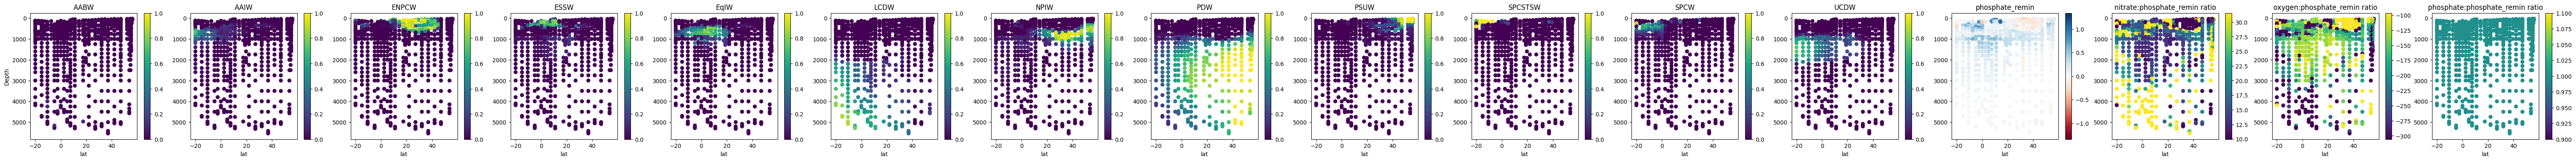

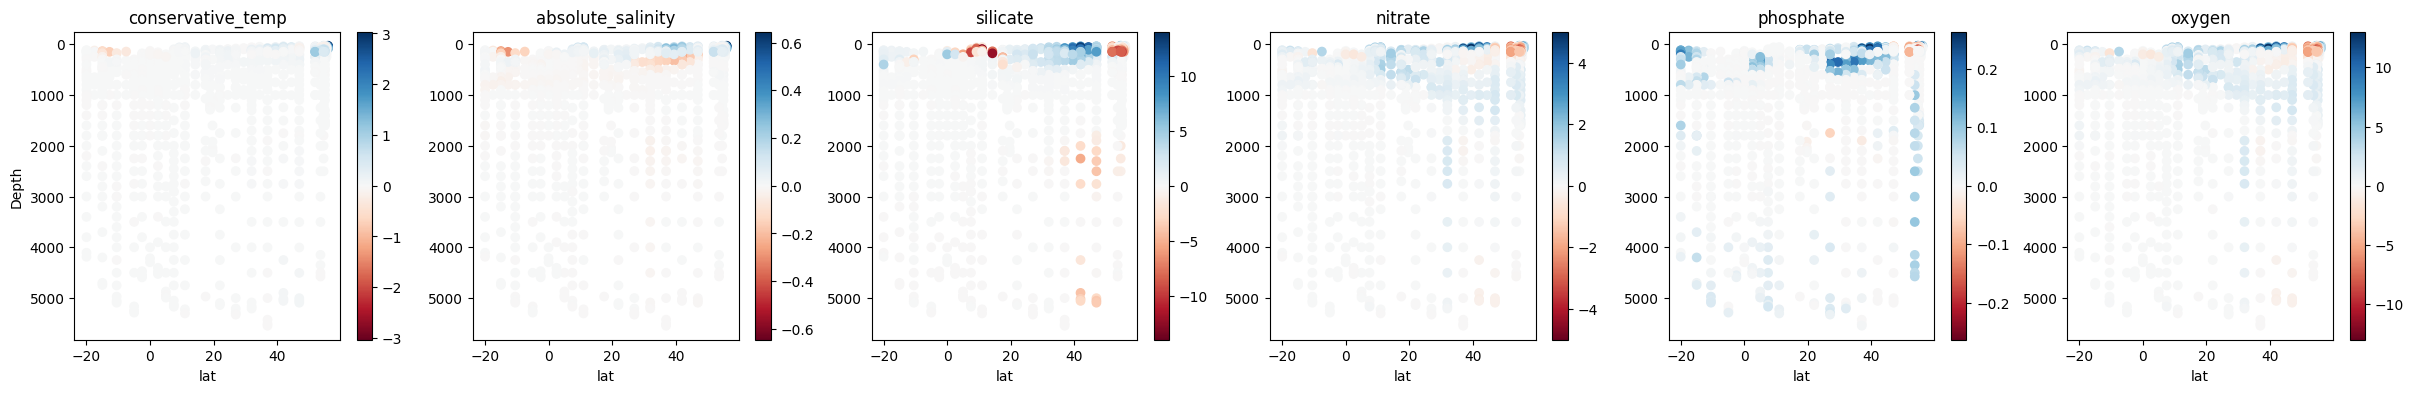

writing to max_AABW_results.csv
writing to min_AABW_results.csv
writing to max_AAIW_results.csv
writing to min_AAIW_results.csv
writing to max_ENPCW_results.csv
writing to min_ENPCW_results.csv


KeyError: ignored

In [27]:
reload(pyompa)
from collections import OrderedDict

ORIG_COLS_TO_INCLUDE = ["lat", "lon", "Depth", "stnnbr", "geotrc_ID", "sigma0"]

base_intermediateanddeep =\
  intermediateanddeep_settingtosoln[INTERANDDEEP_SETTINGTOUSE]
base_thermocline =\
  settings_to_thermoclineomparesults[THERMOCLINE_SETTINGTOUSE]

base_combined = pyompa.ompacore.ExportToCsvMixin.merge(
  exptocsv1=base_intermediateanddeep, exptocsv2=base_thermocline)
base_combined.export_to_csv(
    csv_output_name="baseresults.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

plot_ompasoln_endmember_fractions(ompa_soln=base_combined,
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)
plot_ompasoln_residuals(ompa_soln=base_combined,
                        xaxis_colname="lat",
                        yaxis_colname="Depth")

combined_ambiguity_results_max = OrderedDict()
combined_ambiguity_results_min = OrderedDict()

all_endmembertypes = sorted(set(
    list(interanddeep_ambiguity_results_max.keys())
    +list(thermocline_ambiguity_results_max.keys())))


for endmembername in all_endmembertypes:
  interanddeep_touse_max = base_intermediateanddeep
  interanddeep_touse_min = base_intermediateanddeep
  thermocline_touse_max = base_thermocline
  thermocline_touse_min = base_thermocline
  if endmembername in interanddeep_ambiguity_results_max:
    interanddeep_touse_max = interanddeep_ambiguity_results_max[endmembername]
    interanddeep_touse_min = interanddeep_ambiguity_results_min[endmembername]
  if endmembername in thermocline_ambiguity_results_max:
    thermocline_touse_max = thermocline_ambiguity_results_max[endmembername]
    thermocline_touse_min = thermocline_ambiguity_results_min[endmembername]
  
  combined_ambiguity_results_max[endmembername] =\
    pyompa.ompacore.ExportToCsvMixin.merge(
      exptocsv1=interanddeep_touse_max,
      exptocsv2=thermocline_touse_max)
  combined_ambiguity_results_max[endmembername].export_to_csv(
    csv_output_name="max_"+endmembername+"_results.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE,
    #don't export the residuals cos they haven't been subject
    # to minimization beyond satisfying the constraints
    export_residuals=False)
  
  combined_ambiguity_results_min[endmembername] =\
    pyompa.ompacore.ExportToCsvMixin.merge(
      exptocsv1=interanddeep_touse_min,
      exptocsv2=thermocline_touse_min)
  combined_ambiguity_results_min[endmembername].export_to_csv(
    csv_output_name="min_"+endmembername+"_results.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE,
    export_residuals=False)


for endmembername in all_endmembertypes:
  print("Endmembername:",endmembername)
  #print("Original")
  #plot_ompasoln_endmember_fractions(ompa_soln=base_combined,
  #                              xaxis_colname="lat",
  #                              yaxis_colname="Depth",
  #                              group_endmembers=True)
  print("With min fractions")
  plot_ompasoln_endmember_fractions(
      ompa_soln=combined_ambiguity_results_min[endmembername],
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)
  print("With max fractions")
  plot_ompasoln_endmember_fractions(
      ompa_soln=combined_ambiguity_results_max[endmembername],
                                xaxis_colname="lat",
                                yaxis_colname="Depth",
                                group_endmembers=True)


#print(np.min([x['sig0_cutoffs'][1] for x in station_to_tcstartend.values()]))
#print(np.max([x['sig0_cutoffs'][1] for x in station_to_tcstartend.values()]))

Download to hard drive

In [ ]:
from google.colab import files
import glob

!mkdir ompa_results
!mv *results.csv ompa_results
!zip -r ompa_results.zip ompa_results